In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA GeForce RTX 3090, 24576 MiB, 23130 MiB


## Подготовка данных

1. Собрать датасет от 15 изображений одно персонажа (Чем более разнооразнее и больше данных тем лучше будет качество)
2. Кропнуть и заресайзить лица, тут можно обрабатывать сразу все https://www.birme.net/



## Download model and convert model

In [2]:
!wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml

--2024-04-14 16:36:34--  https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1873 (1,8K) [text/plain]
Saving to: ‘v1-inference.yaml’

v1-inference.yaml   100%[===================>]   1,83K  --.-KB/s    in 0s      

2024-04-14 16:36:34 (93,5 MB/s) - ‘v1-inference.yaml’ saved [1873/1873]



In [3]:
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path='./picxReal_10.safetensors'\
      --original_config_file='./v1-inference.yaml'\
      --dump_path='./model'\
      --scheduler_type="ddim" --prediction_type='epsilon'\
      --from_safetensors

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
config.json: 100%|█████████████████████████| 4.52k/4.52k [00:00<00:00, 37.2MB/s]
tokenizer_config.json: 100%|███████████████████| 905/905 [00:00<00:00, 11.2MB/s]
vocab.json: 100%|████████████████████████████| 961k/961k [00:00<00:00, 2.07MB/s]
merges.txt: 100%|████████████████████████████| 525k/525k [00:00<00:00, 1.63MB/s]
special_tokens_map.json: 100%|█████████████████| 389/389 [00:00<00:00, 4.07MB/s]
tokenizer.json: 100%|██████████████████████| 2.22M/2.22M [00:00<00:00, 5.44MB/s]
config.json: 100%|█████████████████████████| 4.55k/4.55k [00:00<00:00, 40.5MB/s]
pytorch_model.bin: 100%|███████████████████| 1.22G/1.22G [01:49<00:00, 11.1MB/s]
/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/torch/_utils.py:831: UserWar

## Settings and run

# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [1]:
import os
os.environ['INSTANCE_DIR'] = "./instance_images"
os.environ['CLASS_DIR'] = "./class_images"

os.environ['MODEL_NAME'] = "./model"
os.environ['OUTPUT_DIR'] = "./output_dir"

**Тут я сильно поигрался с параметрами:**

1. Добавил gradient accumulation
2. Уменьшил количество шагов (из-за gradient accumulation)
3. Добавил warmup
4. Увеличил sample_batch_size чтобы было быстрее

In [5]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=10 \
  --gradient_accumulation_steps=2 \
  --num_class_images=500 \
  --sample_batch_size=16 \
  --max_train_steps=400 \
  --checkpointing_steps=400 \
  --mixed_precision="no"\
  --train_text_encoder 

/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/accelerate/accelerator.py:391: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
04/15/2024 21:37:20 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly

## Inference

In [26]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display
import os

model_path = os.environ['OUTPUT_DIR']

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float32).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
g_cuda = torch.Generator(device='cuda')
seed = 345252 #@param {type:"number"}
g_cuda.manual_seed(seed)

Loading pipeline components...: 100%|█████████████| 6/6 [00:00<00:00, 25.79it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


100%|███████████████████████████████████████████| 35/35 [00:23<00:00,  1.48it/s]


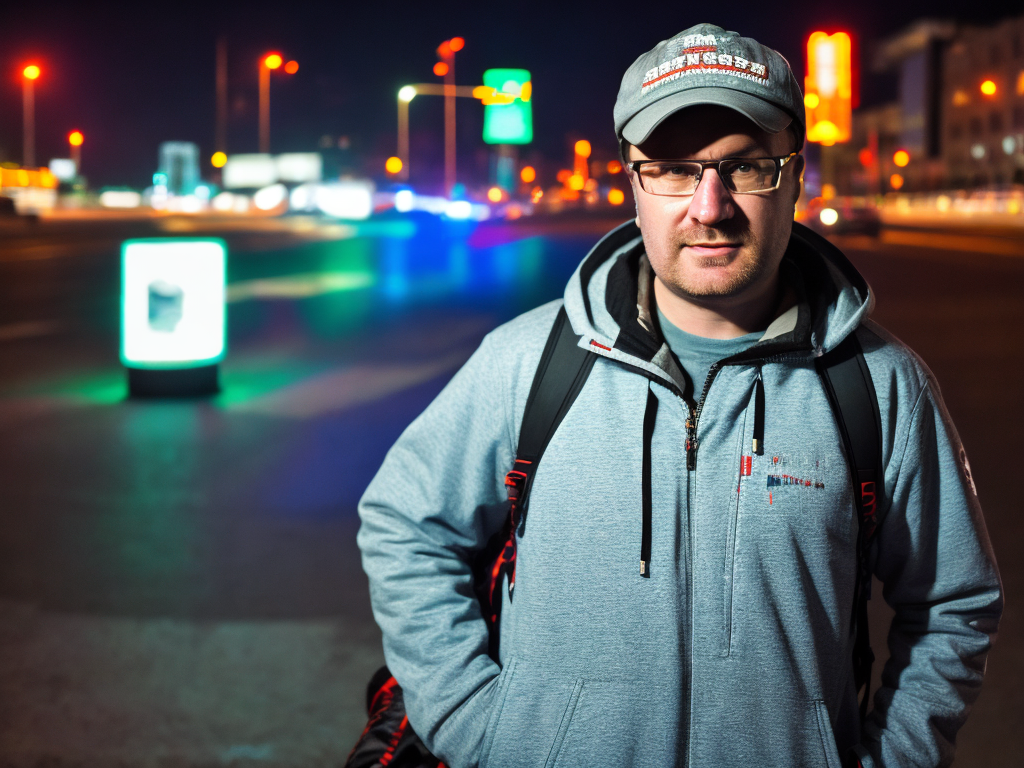

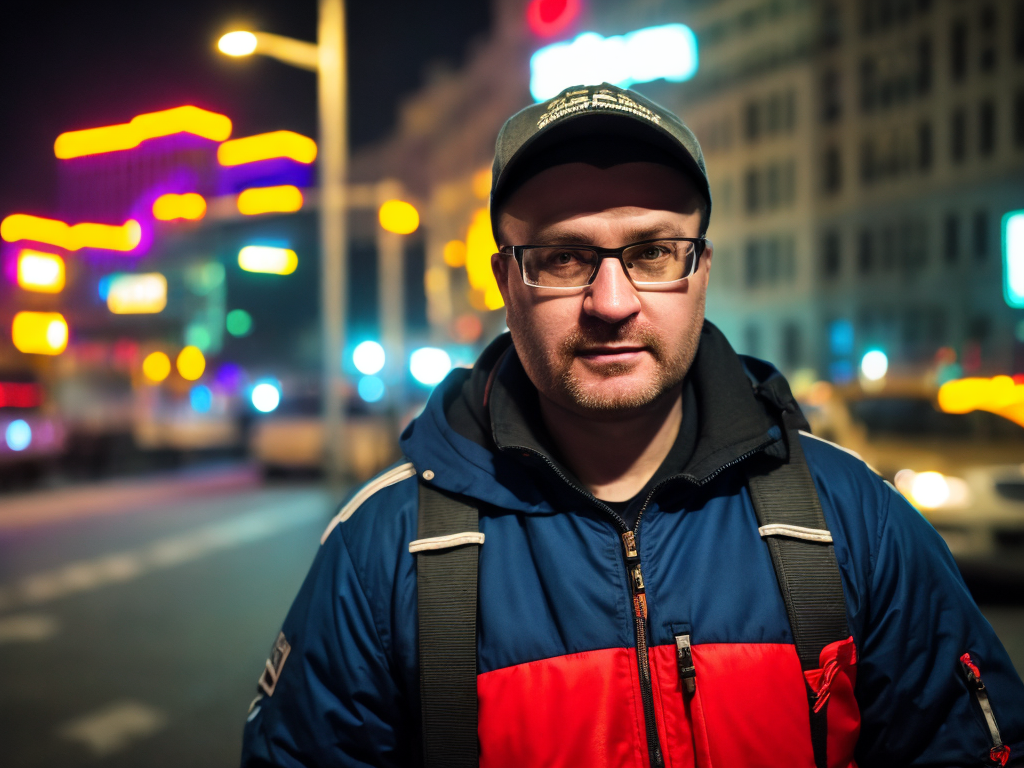

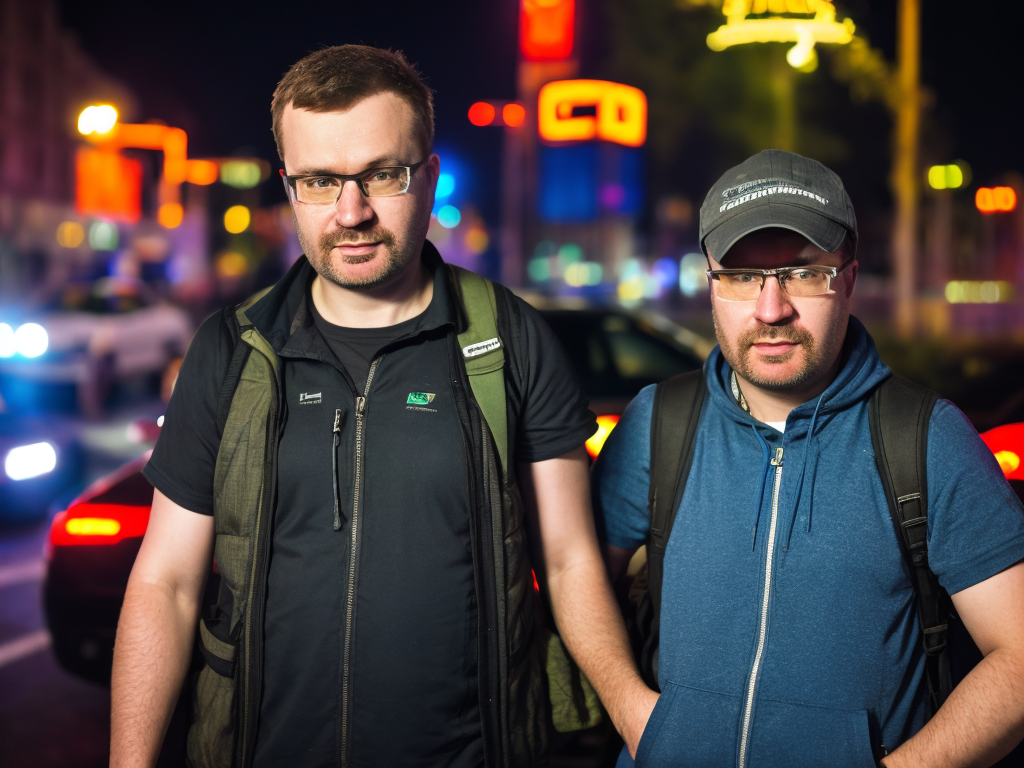

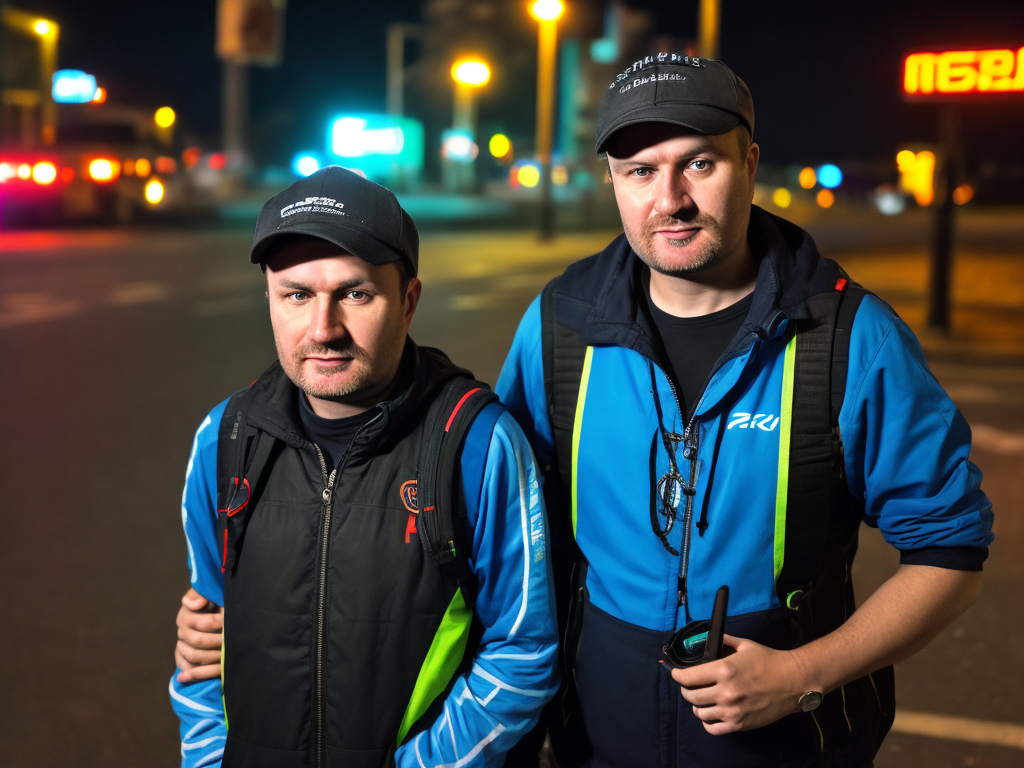

In [27]:
#@title Run for generating images.

prompt = "portrait of sks man face, on the street, lights, midnight, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, detailed eyes, one person"
negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation, multiple persons"
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 35 #@param {type:"number"}
num_samples = 4
height = 768 #@param {type:"number"}
width = 1024 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [28]:
token = "sks"
promt_list = [
    {
     "name": "kitchen",
     "prompt":f"close up portrait of {token} man face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, one person",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation, multiple_persons",
    },
    {
     "name": "forest",
     "prompt":f"portrait of {token} man face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, one person",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation, multiple_persons",
    },
    {
     "name": "street",
     "prompt":f"portrait of {token} man face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes, one person",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry, multiple_persons",
    },
    {
     "name": "football",
     "prompt":f"portrait of {token} man face, playing football, night, football field, lights, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, one person",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry, multiple_persons",
    },
    {
     "name": "office",
     "prompt":f"portrait of {token} man face, in the office, sunset, coffee, sun, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus, one person",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry, multiple_persons",
    },
]

from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [29]:
seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "./report_images"
# save_mode = "with_train_token"
save_mode = "base_model"

for idx, sample in enumerate(promt_list):
  prompt = sample.get("prompt")
  negative_prompt = sample.get("n_prompt")
  name = sample.get("name")
  image_list = []
  for _ in range(repeat):
    generator = torch.Generator("cuda").manual_seed(seed)
    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images
    image_list.extend(images)
    seed+=345324

  img_grid = image_grid(image_list, num_samples, repeat)
  save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
  os.makedirs(save_path, exist_ok=True)
  img_grid.save(os.path.join(save_path, f"{name}.jpg"))

100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.76it/s]


# LoRA

### Rank=64

In [15]:
torch.cuda.empty_cache()

In [16]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir='./lora_outputs/r64' \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=3 \
  --learning_rate=2e-4 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=20 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --sample_batch_size=16 \
  --max_train_steps=150 \
  --checkpointing_steps=150 \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank=64

/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/accelerate/accelerator.py:391: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
04/17/2024 20:49:19 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly

In [23]:
pipe.load_lora_weights("./lora_outputs/r64/checkpoint-150/pytorch_lora_weights.safetensors")

seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "./report_images"
# save_mode = "with_train_token"
save_mode = "lora_r64"

for idx, sample in enumerate(promt_list):
  prompt = sample.get("prompt")
  negative_prompt = sample.get("n_prompt")
  name = sample.get("name")
  image_list = []
  for _ in range(repeat):
    generator = torch.Generator("cuda").manual_seed(seed)
    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images
    image_list.extend(images)
    seed+=345324

  img_grid = image_grid(image_list, num_samples, repeat)
  save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
  os.makedirs(save_path, exist_ok=True)
  img_grid.save(os.path.join(save_path, f"{name}.jpg"))

100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.64it/s]


### Rank=128

In [18]:
torch.cuda.empty_cache()

In [19]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir='./lora_outputs/r128' \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=3 \
  --learning_rate=2e-4 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=20 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --sample_batch_size=16 \
  --max_train_steps=150 \
  --checkpointing_steps=150 \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank=128

/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/accelerate/accelerator.py:391: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
04/17/2024 20:54:16 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly

In [24]:
pipe.load_lora_weights("./lora_outputs/r128/checkpoint-150/pytorch_lora_weights.safetensors")

seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "./report_images"
# save_mode = "with_train_token"
save_mode = "lora_r128"

for idx, sample in enumerate(promt_list):
  prompt = sample.get("prompt")
  negative_prompt = sample.get("n_prompt")
  name = sample.get("name")
  image_list = []
  for _ in range(repeat):
    generator = torch.Generator("cuda").manual_seed(seed)
    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images
    image_list.extend(images)
    seed+=345324

  img_grid = image_grid(image_list, num_samples, repeat)
  save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
  os.makedirs(save_path, exist_ok=True)
  img_grid.save(os.path.join(save_path, f"{name}.jpg"))

100%|███████████████████████████████████████████| 35/35 [00:13<00:00,  2.59it/s]


### Rank=48

In [11]:
torch.cuda.empty_cache()

In [12]:
!python3 ./diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir='./lora_outputs/r48' \
  --instance_prompt="a photo of sks man face" \
  --class_prompt="a photo of man face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=3 \
  --learning_rate=1e-4 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=20 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --sample_batch_size=16 \
  --max_train_steps=350 \
  --checkpointing_steps=350 \
  --mixed_precision="no"\
  --train_text_encoder \
  --rank=48

/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/accelerate/accelerator.py:391: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
04/17/2024 20:30:17 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
/home/peter/anaconda3/envs/torch_generative/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly

In [25]:
pipe.load_lora_weights("./lora_outputs/r48/checkpoint-350/pytorch_lora_weights.safetensors")

seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "./report_images"
# save_mode = "with_train_token"
save_mode = "lora_r48"

for idx, sample in enumerate(promt_list):
  prompt = sample.get("prompt")
  negative_prompt = sample.get("n_prompt")
  name = sample.get("name")
  image_list = []
  for _ in range(repeat):
    generator = torch.Generator("cuda").manual_seed(seed)
    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images
    image_list.extend(images)
    seed+=345324

  img_grid = image_grid(image_list, num_samples, repeat)
  save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
  os.makedirs(save_path, exist_ok=True)
  img_grid.save(os.path.join(save_path, f"{name}.jpg"))

100%|███████████████████████████████████████████| 35/35 [00:14<00:00,  2.50it/s]
